In [1]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

!pip install opencv-python

In [2]:
src1 = cv2.imread('graf1.png', cv2.IMREAD_GRAYSCALE)

src2 = cv2.imread('graf3.png', cv2.IMREAD_GRAYSCALE)

In [4]:
if src1 is None or src2 is None:

    print('Image load failed!')

    sys.exit()

특징점 알고리즘 객체를 생성합니다.

In [5]:
feature = cv2.KAZE_create()

#feature = cv2.AKAZE_create()

#feature = cv2.ORB_create()

특징점 검출 및 기술자 계산

In [6]:
kp1, desc1 = feature.detectAndCompute(src1, None)

kp2, desc2 = feature.detectAndCompute(src2, None)

 특징점 매칭

In [7]:
matcher = cv2.BFMatcher_create()

#matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING)

matches = matcher.match(desc1, desc2)

좋은 매칭 결과 선별을 하기위해 sorting해줍니다.  
그리고 상위 80개만 선별하죠

In [8]:
matches = sorted(matches, key=lambda x: x.distance)

good_matches = matches[:80]

첫번째 이미지의 특징점 선별 개수    
두번째 이미지의 특징점 선별 개수  
매칭된 특징점 개수  
굿 매치 특징점 개수

In [9]:
print('# of kp1:', len(kp1))

print('# of kp2:', len(kp2))

print('# of matches:', len(matches))

print('# of good_matches:', len(good_matches))

# of kp1: 3159
# of kp2: 3625
# of matches: 3159
# of good_matches: 80


# 호모그래피 계산

good_matches가 dematch의 리스트 80개를 하나하나 받아서 m에 받습니다.  
dematch type에는 queryIndex와 trainIndex가 있는데 queryIdx는 1번 이미지의 키포인트 번호입니다. 이걸 kp1에 대한 인덱스 번호로 줍니다. 1번 영상에서 kpt의 인덱스에 해당하는 것을 찾아서 pt라는 점의 좌표를 받아옵니다. pt는 실수와 좌표를 갖는 두개짜리 튜플이며, 이것들을 ndarray로 받아줍니다.  

pts1이 N,1,2로 받아야 하기 때문에 pts1에서 reshape함수를 사용해 바꾸어줍니다.  
호모그래피 perspective Transform을 H로 받았고, 마스크는 받지 않았습니다. 

In [10]:


pts1 = np.array([kp1[m.queryIdx].pt for m in good_matches]

                ).reshape(-1, 1, 2).astype(np.float32)

pts2 = np.array([kp2[m.trainIdx].pt for m in good_matches]

                ).reshape(-1, 1, 2).astype(np.float32)

H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC)

# 호모그래피를 이용하여 기준 영상 영역 표시

In [11]:
dst = cv2.drawMatches(src1, kp1, src2, kp2, good_matches, None,

                      flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


(h, w) = src1.shape[:2]

corners1 = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]

                    ).reshape(-1, 1, 2).astype(np.float32)

corners2 = cv2.perspectiveTransform(corners1, H)

drawMatches를 호출하면 가로로 붙여서 하나로 만들어줍니다.  
2번 영상의 좌표가 1번영상의 가로 크기만큼 shift 되죠. 그걸 반영하기 위해 float32를 더하고 corners에 저장해 줍니다.

In [12]:
corners2 = corners2 + np.float32([w, 0])

In [13]:
cv2.polylines(dst, [np.int32(corners2)], True, (0, 255, 0), 2, cv2.LINE_AA)

array([[[212, 212, 212],
        [210, 210, 210],
        [200, 200, 200],
        ...,
        [ 53,  53,  53],
        [ 53,  53,  53],
        [ 53,  53,  53]],

       [[209, 209, 209],
        [214, 214, 214],
        [213, 213, 213],
        ...,
        [ 58,  58,  58],
        [ 54,  54,  54],
        [ 55,  55,  55]],

       [[213, 213, 213],
        [213, 213, 213],
        [210, 210, 210],
        ...,
        [ 58,  58,  58],
        [ 55,  55,  55],
        [ 51,  51,  51]],

       ...,

       [[ 70,  70,  70],
        [ 66,  66,  66],
        [ 69,  69,  69],
        ...,
        [ 68,  68,  68],
        [ 75,  75,  75],
        [ 83,  83,  83]],

       [[ 68,  68,  68],
        [ 75,  75,  75],
        [ 78,  78,  78],
        ...,
        [ 56,  56,  56],
        [ 52,  52,  52],
        [ 56,  56,  56]],

       [[ 77,  77,  77],
        [ 76,  76,  76],
        [ 76,  76,  76],
        ...,
        [ 43,  43,  43],
        [ 43,  43,  43],
        [ 51,  51,  51]]

((0.0, 1.0, 0.0, 1.0), <matplotlib.image.AxesImage at 0x241a8b62430>)

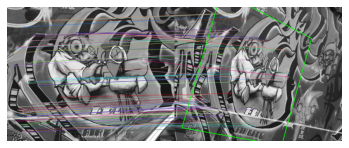

In [14]:
plt.axis('off'),plt.imshow(dst)